# CSCE 421 - Final Project

In [1]:
# Other Imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import imblearn
import random
from sklearn.ensemble import RandomForestClassifier
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
import joblib
import pickle
import statistics  as s

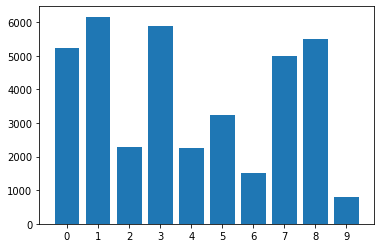

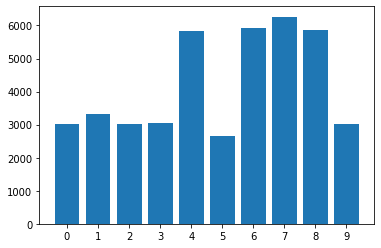

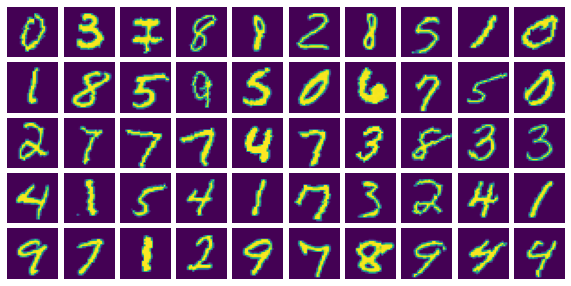

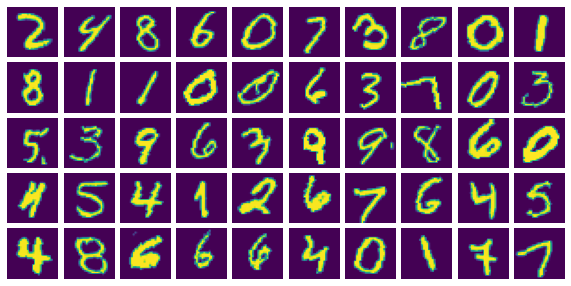

In [2]:
# %%
import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
parser.add_argument('--nrow', type=int, default=5,
                    help='rows of example')
parser.add_argument('--ncol', type=int, default=10,
                    help='columns of example')
parser.add_argument('-f')

args = parser.parse_args()

torch.manual_seed(args.seed)

# %%
imbalanced_linear_train_dataset = torch.load('imbalanced_linear_train_dataset.pt')
imbalanced_linear_train_loader = torch.utils.data.DataLoader(imbalanced_linear_train_dataset, batch_size=args.batch_size, shuffle=True)

imbalanced_step_train_dataset = torch.load('imbalanced_step_train_dataset.pt')
imbalanced_step_train_loader = torch.utils.data.DataLoader(imbalanced_step_train_dataset, batch_size=args.batch_size, shuffle=True)

# %%
test_dataset = torch.load('test_dataset.pt')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True)

# %%
import matplotlib.pyplot as plt

import seaborn as sns


def show_mnist(arr, nrow=args.nrow, ncol=args.ncol, figsize=None):
    
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
    plt.savefig('examples.png')


#print('Distribution of classes in linear imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_linear_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist linear.png')
# plt.show()


#print('Distribution of classes in step imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_step_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist step.png')
# plt.show()


for data, _ in imbalanced_linear_train_loader:
    show_mnist(data)
    break
    
for data, _ in imbalanced_step_train_loader:
    show_mnist(data)
    break

# %%


# DATA MANIPULATION

In [3]:
# imbalanced_linear_train_dataset into a numpy array of flattened image data from loader
imbalanced_linear_train_tensor = []
imbalanced_linear_train_dataArray = []
imbalanced_linear_train_labels = []
for img, labels in imbalanced_linear_train_loader:
    for data in img:
        imbalanced_linear_train_tensor.append(data.numpy())
        imbalanced_linear_train_dataArray.append(data[0].reshape(1,-1).numpy()[0])
    for sub_label in labels:
        imbalanced_linear_train_labels.append(sub_label.item())

# imbalanced_step_train_dataset into a numpy array of flattened image data from loader
imbalanced_step_train_tensor = []
imbalanced_step_train_dataArray = []
imbalanced_step_train_labels = []
for img, labels in imbalanced_step_train_loader:
    for data in img:
        imbalanced_step_train_tensor.append(data.numpy())
        imbalanced_step_train_dataArray.append(data[0].reshape(1,-1).numpy()[0])
    for sub_label in labels:
        imbalanced_step_train_labels.append(sub_label.item())
        
# test_dataset into a numpy array of flattened image data from loader
test_dataArray = []
test_labels = []
test_tensor = []
for img, labels in test_loader:
    for data in img:
        test_tensor.append(data.numpy())
        test_dataArray.append(data[0].reshape(1,-1).numpy()[0])
    for sub_label in labels:
        test_labels.append(sub_label.item())

In [4]:
# Normalize data to mean of 0 and variance of 1
scaler = StandardScaler()
scaler.fit(imbalanced_linear_train_dataArray)
imbalanced_linear_train_dataArray = scaler.transform(imbalanced_linear_train_dataArray)
imbalanced_step_train_dataArray = scaler.transform(imbalanced_step_train_dataArray)
test_dataArray =scaler.transform(test_dataArray)

# Converting list to numpy arrays
imbalanced_linear_train_dataArray = np.array(imbalanced_linear_train_dataArray)
imbalanced_linear_train_labels = np.array(imbalanced_linear_train_labels)
imbalanced_step_train_dataArray = np.array(imbalanced_step_train_dataArray)
imbalanced_step_train_labels = np.array(imbalanced_step_train_labels)
test_dataArray = np.array(test_dataArray)
test_labels = np.array(test_labels)

test_dataArray_save=torch.from_numpy(test_dataArray)
test_labels_save = torch.from_numpy(test_labels)

# Checking shapes of all data & label arrays for Logistic Regression and Random Forest Classifier
test_tensor = torch.from_numpy(np.array(test_tensor))
test_labels_tensor = torch.from_numpy(np.array(test_labels).astype('int64'))



print("test_tensor:                           ", test_tensor.shape)
print("test_labels_tensor:                    ", test_labels_tensor.shape)
print()
# Checking shapes of all data & label arrays for Logistic Regression and Random Forest Classifier
print("LOG REG AND RF DATA")
print("reshaped imbalanced_linear_train:         ",imbalanced_linear_train_dataArray.shape)
print("imbalanced_linear_train_labels:           ", imbalanced_linear_train_labels.shape)
print()
print("reshaped imbalanced_step_train_dataArray: ",imbalanced_step_train_dataArray.shape)
print("imbalanced_step_train_labels:             ", imbalanced_step_train_labels.shape)
print()
print("reshaped test_dataArray:                  ",test_dataArray.shape)
print("test_labels:                              ", test_labels.shape)

test_tensor:                            torch.Size([10000, 1, 28, 28])
test_labels_tensor:                     torch.Size([10000])

LOG REG AND RF DATA
reshaped imbalanced_linear_train:          (37879, 784)
imbalanced_linear_train_labels:            (37879,)

reshaped imbalanced_step_train_dataArray:  (41964, 784)
imbalanced_step_train_labels:              (41964,)

reshaped test_dataArray:                   (10000, 784)
test_labels:                               (10000,)


In [5]:
# Transforming imbalanced data using over and under sampling to see effect on models

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

oversample = RandomOverSampler(sampling_strategy='minority')
undersample = RandomUnderSampler(sampling_strategy='majority')

# Oversample so that the distribution of minority matches majority classes
linear_over_X, linear_over_y=oversample.fit_resample(imbalanced_linear_train_dataArray, imbalanced_linear_train_labels)
step_over_X, step_over_y=oversample.fit_resample(imbalanced_step_train_dataArray, imbalanced_step_train_labels)
print(linear_over_X.shape)
print(linear_over_y.shape)
print(step_over_X.shape)

linear_over_X_temp = []
step_over_X_temp = []
# Create tensors and dataloader of over sampled training datasets
for i in range(len(linear_over_X)):
    linear_over_X_temp.append(linear_over_X[i].reshape(1,28,28))
for i in range(len(step_over_X)):
    step_over_X_temp.append(step_over_X[i].reshape(1,28,28))
    
linear_over_X_tensor = torch.tensor(linear_over_X_temp)
linear_over_y_tensor = torch.tensor(linear_over_y.astype('int64'))
step_over_X_tensor = torch.tensor(step_over_X_temp)
step_over_y_tensor = torch.tensor(step_over_y.astype('int64'))

linear_over_tensor = torch.utils.data.TensorDataset(linear_over_X_tensor, linear_over_y_tensor)
step_over_tensor = torch.utils.data.TensorDataset(step_over_X_tensor, step_over_y_tensor)

linear_over_tensor_loader = torch.utils.data.DataLoader(linear_over_tensor, batch_size=args.batch_size, shuffle=True)
step_over_tensor_loader = torch.utils.data.DataLoader(step_over_tensor, batch_size=args.batch_size, shuffle=True)

# Undersample so that the distribution of majority matches minority classes
linear_under_X, linear_under_y=undersample.fit_resample(imbalanced_linear_train_dataArray, imbalanced_linear_train_labels)
step_under_X, step_under_y=undersample.fit_resample(imbalanced_step_train_dataArray, imbalanced_step_train_labels)
print(linear_under_X.shape)
print(linear_under_y.shape)
print(step_under_X.shape)

linear_under_X_temp = []
step_under_X_temp = []
# Create tensors and dataloader of under sampled training datasets
for i in range(len(linear_under_X)):
    linear_under_X_temp.append(linear_under_X[i].reshape(1,28,28))
for i in range(len(step_under_X)):
    step_under_X_temp.append(step_under_X[i].reshape(1,28,28))
    
linear_under_X_tensor = torch.tensor(linear_under_X_temp)
linear_under_y_tensor = torch.tensor(linear_under_y.astype('int64'))
step_under_X_tensor = torch.tensor(step_under_X_temp)
step_under_y_tensor = torch.tensor(step_under_y.astype('int64'))

linear_under_tensor = torch.utils.data.TensorDataset(linear_under_X_tensor, linear_under_y_tensor)
step_under_tensor = torch.utils.data.TensorDataset(step_under_X_tensor, step_under_y_tensor)

linear_under_tensor_loader = torch.utils.data.DataLoader(linear_under_tensor, batch_size=args.batch_size, shuffle=True)
step_under_tensor_loader = torch.utils.data.DataLoader(step_under_tensor, batch_size=args.batch_size, shuffle=True)

(43256, 784)
(43256,)
(45560, 784)
(32502, 784)
(32502,)
(38368, 784)


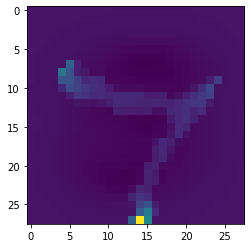

7


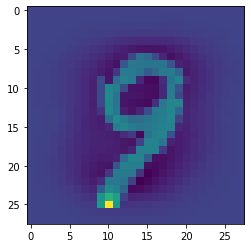

9


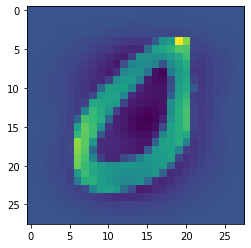

0


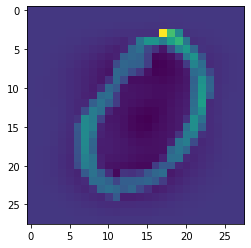

0


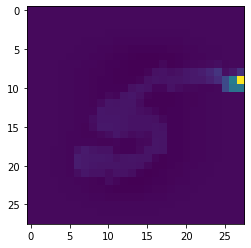

5


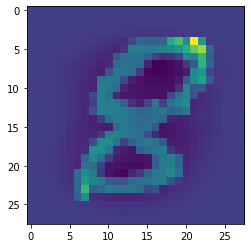

8


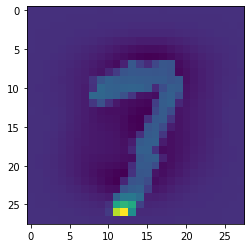

7


In [6]:
# Testing Different images and labels between different datasets to see if data and labels match
# random.seed(15)
rand1=random.randint(0,len(imbalanced_linear_train_dataArray))
plt.imshow(imbalanced_linear_train_dataArray[rand1].reshape(28,28))
plt.show()
print(imbalanced_linear_train_labels[rand1])

rand2=random.randint(0,len(imbalanced_step_train_dataArray))
plt.imshow(imbalanced_step_train_dataArray[rand2].reshape(28,28))
plt.show()
print(imbalanced_step_train_labels[rand2])

rand3=random.randint(0,len(test_dataArray))
plt.imshow(test_dataArray[rand3].reshape(28,28))
plt.show()
print(test_labels[rand3])

rand4=random.randint(0,len(linear_over_X))
plt.imshow(linear_over_X[rand4].reshape(28,28))
plt.show()
print(linear_over_y[rand4])

rand5=random.randint(0,len(step_over_X))
plt.imshow(step_over_X[rand5].reshape(28,28))
plt.show()
print(step_over_y[rand5])

rand6=random.randint(0,len(linear_under_X))
plt.imshow(linear_under_X[rand6].reshape(28,28))
plt.show()
print(linear_under_y[rand6])

rand7=random.randint(0,len(step_under_X))
plt.imshow(step_under_X[rand7].reshape(28,28))
plt.show()
print(step_under_y[rand7])

In [7]:
# Used in training the models
datasets_linear = ['imbalanced_linear_trained','overSampled_linear_trained','underSampled_linear_trained']
datasets_step = ['imbalanced_step_trained','overSampled_step_trained','underSampled_step_trained']
y_train_labelSets_linear = [imbalanced_linear_train_labels, linear_over_y, linear_under_y]
y_train_labelSets_step = [imbalanced_step_train_labels, step_over_y, step_under_y]

In [8]:
# Save these for testing
# Save test_tensor
torch.save(test_tensor, 'test_tensor.pt')
# Save test_dataArray
torch.save(test_dataArray_save, 'test_dataArray.pt')
# Save test_labels
torch.save(test_labels_save, 'test_labels.pt')


# Convolutional Neural Network Implementation

In [9]:
# Using python notebook example as base
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input shape (1,28,28)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, #input channels
                      out_channels=32, #n_filter
                     kernel_size=5, #filter size
                     stride=1, #filter step
                     padding=0 #same output size
                     ), #shape (32,24,24)|
            nn.ReLU(), #fully-connected layer
            nn.MaxPool2d(kernel_size=2, stride=2)) #max pooling layer. 2x2 sampling
        #output shape (32,12,12)
        
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 5, 1, 0), nn.ReLU(),nn.MaxPool2d(2,2))
        # inner shape (32,8,8)
#         output shape (32,4,4)
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 4, 1, 0), nn.ReLU())
        #output shape (64,1,1)
        self.conv4 = nn.Sequential(nn.Conv2d(64, 256, 1, 1, 0), nn.ReLU())
        #output shape (256,1,1)

        self.out = nn.Linear(256*1*1,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #Flatten
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output
    


In [10]:
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)

if torch.cuda.is_available():
    cnn_model=cnn_model.cuda()
    criterion=criterion.cuda()
loss_list_linear = []
for epoch in range(8): 
    running_loss = 0.0
    for i, data in enumerate(imbalanced_linear_train_loader,0):
    # get the inputs; data is a list of [inputs, labels]
        X_train,y_train=data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % args.batch_size == 63:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss/args.batch_size))
            loss_list_linear.append(running_loss/args.batch_size)
            running_loss = 0.0

pickle.dump(cnn_model, open('imbalanced_linear_trained_CNN.pkl','wb'));                  

In [11]:
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)

loss_list_step = []
for epoch in range(8): 
    running_loss = 0.0
    for i, data in enumerate(imbalanced_step_train_loader,0):
    # get the inputs; data is a list of [inputs, labels]
        X_train,y_train=data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % args.batch_size == 63:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss/args.batch_size))
            loss_list_step.append(running_loss/args.batch_size)
            running_loss = 0.0
        
pickle.dump(cnn_model, open('imbalanced_step_trained_CNN.pkl','wb'));

In [12]:
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)

if torch.cuda.is_available():
    cnn_model=cnn_model.cuda()
    criterion=criterion.cuda()
cnn_model = cnn_model.float()

loss_list_linear = []
for epoch in range(8): 
    running_loss = 0.0
    for i, data in enumerate(linear_over_tensor_loader,0):
    # get the inputs; data is a list of [inputs, labels]
        X_train,y_train=data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(X_train.float())
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % args.batch_size == 63:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss/args.batch_size))
            loss_list_linear.append(running_loss/args.batch_size)
            running_loss = 0.0

pickle.dump(cnn_model, open('overSampled_linear_trained_CNN.pkl','wb'));                  

In [13]:
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)

if torch.cuda.is_available():
    cnn_model=cnn_model.cuda()
    criterion=criterion.cuda()
cnn_model = cnn_model.float()
loss_list_linear = []
for epoch in range(8): 
    running_loss = 0.0
    for i, data in enumerate(step_over_tensor_loader,0):
    # get the inputs; data is a list of [inputs, labels]
        X_train,y_train=data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(X_train.float())
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % args.batch_size == 63:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss/args.batch_size))
            loss_list_linear.append(running_loss/args.batch_size)
            running_loss = 0.0

pickle.dump(cnn_model, open('overSampled_step_trained_CNN.pkl','wb'));                  

In [14]:
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)

if torch.cuda.is_available():
    cnn_model=cnn_model.cuda()
    criterion=criterion.cuda()
cnn_model = cnn_model.float()

loss_list_linear = []
for epoch in range(8): 
    running_loss = 0.0
    for i, data in enumerate(linear_under_tensor_loader,0):
    # get the inputs; data is a list of [inputs, labels]
        X_train,y_train=data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(X_train.float())
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % args.batch_size == 63:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss/args.batch_size))
            loss_list_linear.append(running_loss/args.batch_size)
            running_loss = 0.0

pickle.dump(cnn_model, open('underSampled_linear_trained_CNN.pkl', 'wb'));                  

In [15]:
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)

if torch.cuda.is_available():
    cnn_model=cnn_model.cuda()
    criterion=criterion.cuda()
cnn_model = cnn_model.float()

loss_list_linear = []
for epoch in range(7): 
    running_loss = 0.0
    for i, data in enumerate(step_under_tensor_loader,0):
    # get the inputs; data is a list of [inputs, labels]
        X_train,y_train=data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(X_train.float())
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % args.batch_size == 63:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss/args.batch_size))
            loss_list_linear.append(running_loss/args.batch_size)
            running_loss = 0.0

pickle.dump(cnn_model, open('underSampled_step_trained_CNN.pkl','wb'));                  

# Logistic Regression Implementation

In [16]:
hyperparameters = {'C': [0.001, .01, .1], 'max_iter':[1e8], 'solver':['lbfgs']}

In [17]:
X_train_dataSets= [pd.DataFrame(imbalanced_linear_train_dataArray), pd.DataFrame(linear_over_X), pd.DataFrame(linear_under_X)]

for i in range(3):
    y_train_labelSets_linear[i] = pd.DataFrame(y_train_labelSets_linear[i])
    skf=StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(X_train_dataSets[i], y_train_labelSets_linear[i]):

        X_train, X_test = X_train_dataSets[i].iloc[train_index], X_train_dataSets[i].iloc[test_index]
        y_train, y_test = y_train_labelSets_linear[i].iloc[train_index].values.ravel(), y_train_labelSets_linear[i].iloc[test_index].values.ravel() 

        logisticReg_linear = LogisticRegression()
        logisticReg_linear_cv = GridSearchCV(logisticReg_linear, hyperparameters, cv=5, n_jobs=-1)
        logisticReg_linear_cv.fit(X_train, y_train) 
        
    pickle.dump(logisticReg_linear_cv, open(datasets_linear[i]+'_LogReg.pkl', 'wb'));

In [18]:
X_train_dataSets = [pd.DataFrame(imbalanced_step_train_dataArray), pd.DataFrame(step_over_X), pd.DataFrame(step_under_X)]

for i in range(3):
    y_train_labelSets_step[i] = pd.DataFrame(y_train_labelSets_step[i])
    skf=StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(X_train_dataSets[i], y_train_labelSets_step[i]):
    
        X_train, X_test = X_train_dataSets[i].iloc[train_index], X_train_dataSets[i].iloc[test_index]
        y_train, y_test = y_train_labelSets_step[i].iloc[train_index].values.ravel(), y_train_labelSets_step[i].iloc[test_index].values.ravel() 

        logisticReg_step = LogisticRegression()
        logisticReg_step_cv = GridSearchCV(logisticReg_step,hyperparameters, cv=5, n_jobs=-1)
        logisticReg_step_cv.fit(X_train, y_train) 
        
    pickle.dump(logisticReg_step_cv, open(datasets_step[i]+'_LogReg.pkl', 'wb'));

# Random Forest Implementation

In [19]:
hyperparameters = {'n_estimators': [10,50,100,150], 'criterion':['entropy'], 'max_depth': [1,3,5,10]}

In [20]:
X_train_dataSets= [pd.DataFrame(imbalanced_linear_train_dataArray), pd.DataFrame(linear_over_X), pd.DataFrame(linear_under_X)]

for i in range(3):
    y_train_labelSets_linear[i] = pd.DataFrame(y_train_labelSets_linear[i])
    skf=StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(X_train_dataSets[i], y_train_labelSets_linear[i]):

        X_train, X_test = X_train_dataSets[i].iloc[train_index], X_train_dataSets[i].iloc[test_index]
        y_train, y_test = y_train_labelSets_linear[i].iloc[train_index].values.ravel(), y_train_labelSets_linear[i].iloc[test_index].values.ravel() 

        rf_linear = RandomForestClassifier()
        rf_linear_cv = GridSearchCV(rf_linear, hyperparameters, cv=5, n_jobs=-1)
        rf_linear_cv.fit(X_train, y_train)

    pickle.dump(rf_linear_cv, open(datasets_linear[i]+'_rf.pkl', 'wb'));

In [21]:
X_train_dataSets= [pd.DataFrame(imbalanced_step_train_dataArray), pd.DataFrame(step_over_X), pd.DataFrame(step_under_X)]

for i in range(3):
    y_train_labelSets_step[i]= pd.DataFrame(y_train_labelSets_step[i])
    skf=StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(X_train_dataSets[i], y_train_labelSets_step[i]):

        X_train, X_test = X_train_dataSets[i].iloc[train_index], X_train_dataSets[i].iloc[test_index]
        y_train, y_test = y_train_labelSets_step[i].iloc[train_index].values.ravel(), y_train_labelSets_step[i].iloc[test_index].values.ravel() 

        rf_step = RandomForestClassifier()
        rf_step_cv = GridSearchCV(rf_step, hyperparameters, cv=5, n_jobs=-1)
        rf_step_cv.fit(X_train, y_train)

    pickle.dump(rf_step_cv, open(datasets_step[i]+'_rf.pkl', 'wb'));

# Grader compile starting here till the end

# Predict on Fitted Models and Results. 
#### There are 6 models for each of the three classifiers because of imblanced, oversampled and undersampled for linear and step imbalanced training data.

In [46]:
# Imports
import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

# Other Imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import imblearn
import random
from sklearn.ensemble import RandomForestClassifier
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
import joblib
import pickle
import statistics  as s

# Used for naming files and models
datasets_linear = ['imbalanced_linear_trained','overSampled_linear_trained','underSampled_linear_trained']
datasets_step = ['imbalanced_step_trained','overSampled_step_trained','underSampled_step_trained']

# Load data for testing
test_tensor=torch.load('test_tensor.pt')
test_dataArray=torch.load('test_dataArray.pt').numpy()
test_labels=torch.load('test_labels.pt').numpy()

# Grader please change the variables to the held out test data below

In [47]:
X_test_cnn = test_tensor # 4 dimensional tensor 
X_test_LR_RF = test_dataArray # 2 dimensional numpy array
y_test = test_labels # 1 dimensional numpy array

In [48]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [49]:
# produces the different plots and results used for testing and interpreting the models
def results(test_labels, predictions, prob, dataset, model):
    classes=[str(i) for i in range(10)]
    sns_plot=sns.heatmap(confusion_matrix(test_labels, predictions, labels = [i for i in range(10)]),annot=True, cmap='Blues', fmt='g')
    sns_plot.set(xlabel="predicted", ylabel = "true", title="Confusion Matrix for "+model+" trained on "+dataset+" data tested on test data:");
    plt.savefig("ConfusionMatrices/Confusion_Matrix_"+model+"_trained_"+dataset)
    plt.show()
    print()
    print("MutliClass ROC AUC score using labelBinarizer on prediction labels for "+model+" trained on "+dataset+" data and tested on test data: ", multiclass_roc_auc_score(test_labels, predictions))
    print("ROC AUC Score using probabilities for "+model+" trained on "+dataset+" data and tested on test data: ", roc_auc_score(test_labels, prob, multi_class='ovr', average='macro'))  
    print()        

# Linear CNN Models

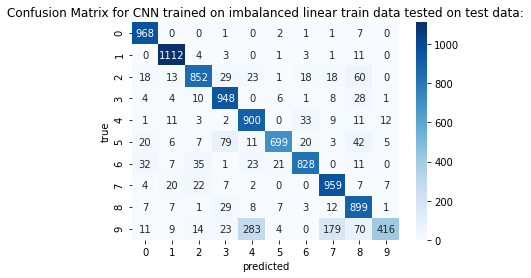


MutliClass ROC AUC score using labelBinarizer on prediction labels for CNN trained on imbalanced linear train data and tested on test data:  0.9203309894939945
ROC AUC Score using probabilities for CNN trained on imbalanced linear train data and tested on test data:  0.9916442847288076



In [50]:
loaded_linear_cnn_model = pickle.load(open('imbalanced_linear_trained_CNN.pkl','rb'))
with torch.no_grad():
    output = loaded_linear_cnn_model(X_test_cnn)

softmax = nn.Softmax(dim=1)
prob = softmax(output)
predictions = np.argmax(prob, axis=1)

results(y_test, predictions, prob, "imbalanced linear train", "CNN")

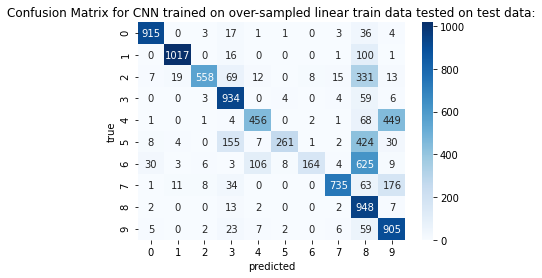


MutliClass ROC AUC score using labelBinarizer on prediction labels for CNN trained on over-sampled linear train data and tested on test data:  0.8231865115898735
ROC AUC Score using probabilities for CNN trained on over-sampled linear train data and tested on test data:  0.9802822452342195



In [51]:
loaded_linear_cnn_model = pickle.load(open('overSampled_linear_trained_CNN.pkl','rb'))
with torch.no_grad():
    output = loaded_linear_cnn_model(X_test_cnn)

softmax = nn.Softmax(dim=1)
prob = softmax(output)
predictions = np.argmax(prob, axis=1)

results(y_test, predictions, prob, "over-sampled linear train", "CNN")

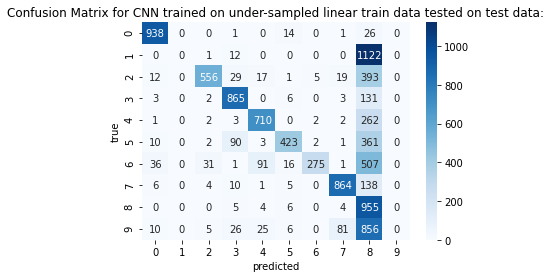


MutliClass ROC AUC score using labelBinarizer on prediction labels for CNN trained on under-sampled linear train data and tested on test data:  0.7584200623365643
ROC AUC Score using probabilities for CNN trained on under-sampled linear train data and tested on test data:  0.9679504657455645



In [71]:
# Not needed model. Predictions of two classes are not predicted so this is not an adequate result to compare against.
loaded_linear_cnn_model = pickle.load(open('underSampled_linear_trained_CNN.pkl', 'rb'))
with torch.no_grad():
    output = loaded_linear_cnn_model(test_tensor)

softmax = nn.Softmax(dim=1)
prob = softmax(output)
predictions = np.argmax(prob, axis=1)

results(test_labels, predictions, prob, "under-sampled linear train", "CNN")

# Step CNN Models

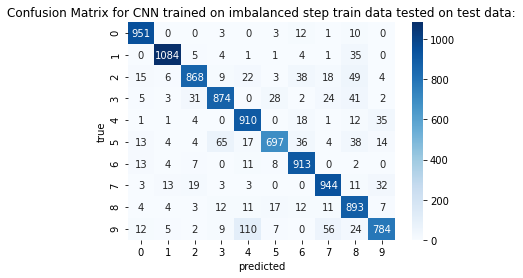


MutliClass ROC AUC score using labelBinarizer on prediction labels for CNN trained on imbalanced step train data and tested on test data:  0.9392515147103315
ROC AUC Score using probabilities for CNN trained on imbalanced step train data and tested on test data:  0.9921714741928419



In [53]:
loaded_step_cnn_model = pickle.load(open('imbalanced_step_trained_CNN.pkl','rb'))

with torch.no_grad():
    output = loaded_step_cnn_model(X_test_cnn)
softmax = nn.Softmax(dim=1)
prob = softmax(output)
predictions = np.argmax(prob, axis=1)

results(y_test, predictions, prob, "imbalanced step train", "CNN")

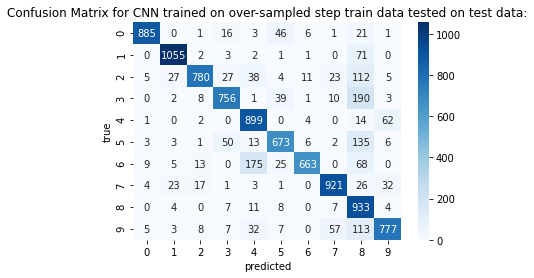


MutliClass ROC AUC score using labelBinarizer on prediction labels for CNN trained on over-sampled step train data and tested on test data:  0.90694516190214
ROC AUC Score using probabilities for CNN trained on over-sampled step train data and tested on test data:  0.9865106014559355



In [54]:
loaded_step_cnn_model = pickle.load(open('oversampled_step_trained_CNN.pkl','rb'))

with torch.no_grad():
    output = loaded_step_cnn_model(X_test_cnn)
softmax = nn.Softmax(dim=1)
prob = softmax(output)
predictions = np.argmax(prob, axis=1)

results(y_test, predictions, prob, "over-sampled step train", "CNN")

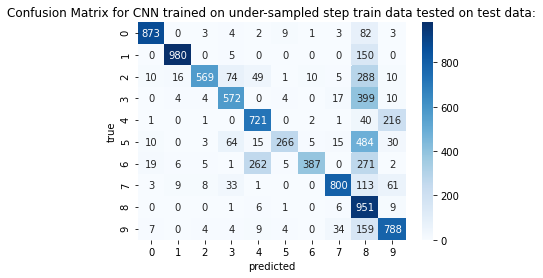


MutliClass ROC AUC score using labelBinarizer on prediction labels for CNN trained on under-sampled step train data and tested on test data:  0.8250420509874348
ROC AUC Score using probabilities for CNN trained on under-sampled step train data and tested on test data:  0.9715700480651404



In [55]:
# Due to error of other undersampled model I do not use this in the report but it is here for 
# additional data
loaded_step_cnn_model = pickle.load(open('undersampled_step_trained_CNN.pkl','rb'))

with torch.no_grad():
    output = loaded_step_cnn_model(X_test_cnn)
softmax = nn.Softmax(dim=1)
prob = softmax(output)
predictions = np.argmax(prob, axis=1)

results(y_test, predictions, prob, "under-sampled step train", "CNN")

# Linear Logistic Regression Models

Best Parameters from Grid CV is:  {'C': 0.01, 'max_iter': 100000000.0, 'solver': 'lbfgs'}



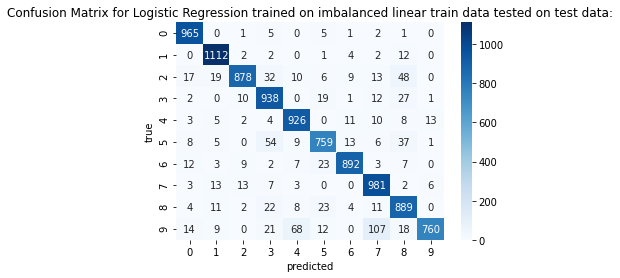


MutliClass ROC AUC score using labelBinarizer on prediction labels for Logistic Regression trained on imbalanced linear train data and tested on test data:  0.9494576183060689
ROC AUC Score using probabilities for Logistic Regression trained on imbalanced linear train data and tested on test data:  0.9928224757084477



In [56]:
loaded_imbalancedLinear_logReg_model = pickle.load(open('imbalanced_linear_trained_LogReg.pkl','rb'))

y_predLogReg_linear=loaded_imbalancedLinear_logReg_model.predict(X_test_LR_RF)
y_probLogReg_linear=loaded_imbalancedLinear_logReg_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_imbalancedLinear_logReg_model.best_params_)
print()
results(y_test, y_predLogReg_linear, y_probLogReg_linear, "imbalanced linear train", "Logistic Regression")

Best Parameters from Grid CV is:  {'C': 0.01, 'max_iter': 100000000.0, 'solver': 'lbfgs'}



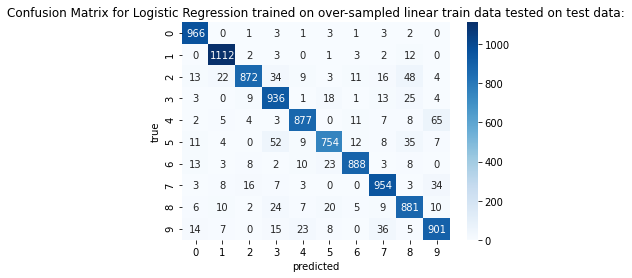


MutliClass ROC AUC score using labelBinarizer on prediction labels for Logistic Regression trained on over-sampled linear train data and tested on test data:  0.9516255850211024
ROC AUC Score using probabilities for Logistic Regression trained on over-sampled linear train data and tested on test data:  0.9928230406957386



In [57]:
loaded_overLinear_logReg_model = pickle.load(open('overSampled_linear_trained_LogReg.pkl','rb'))

y_predLogReg_linear=loaded_overLinear_logReg_model.predict(X_test_LR_RF)
y_probLogReg_linear=loaded_overLinear_logReg_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_overLinear_logReg_model.best_params_)
print()
results(y_test, y_predLogReg_linear, y_probLogReg_linear, "over-sampled linear train", "Logistic Regression")

Best Parameters from Grid CV is:  {'C': 0.01, 'max_iter': 100000000.0, 'solver': 'lbfgs'}



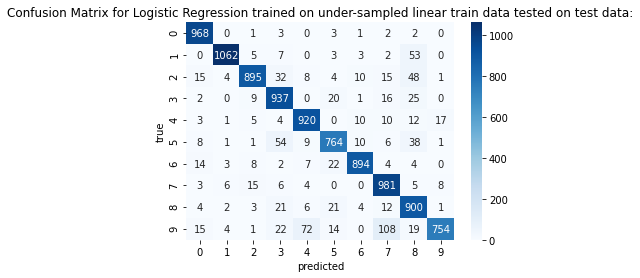


MutliClass ROC AUC score using labelBinarizer on prediction labels for Logistic Regression trained on under-sampled linear train data and tested on test data:  0.9483936591238029
ROC AUC Score using probabilities for Logistic Regression trained on under-sampled linear train data and tested on test data:  0.9925157695016811



In [58]:
loaded_underLinear_logReg_model = pickle.load(open('underSampled_linear_trained_LogReg.pkl','rb'))

y_predLogReg_linear=loaded_underLinear_logReg_model.predict(X_test_LR_RF)
y_probLogReg_linear=loaded_underLinear_logReg_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_underLinear_logReg_model.best_params_)
print()
results(y_test, y_predLogReg_linear, y_probLogReg_linear, "under-sampled linear train", "Logistic Regression")

# Step Logisitic Regression Models

Best Parameters from Grid CV is:  {'C': 0.01, 'max_iter': 100000000.0, 'solver': 'lbfgs'}



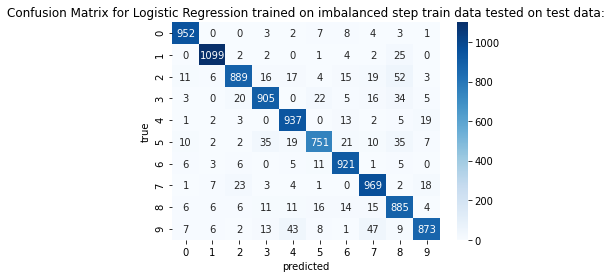


MutliClass ROC AUC score using labelBinarizer on prediction labels for Logistic Regression trained on imbalanced step train data and tested on test data:  0.9540097699794063
ROC AUC Score using probabilities for Logistic Regression trained on imbalanced step train data and tested on test data:  0.9929404508548444



In [59]:
loaded_imbalancedStep_logReg_model = pickle.load(open('imbalanced_step_trained_LogReg.pkl','rb'))

y_predLogReg_step=loaded_imbalancedStep_logReg_model.predict(X_test_LR_RF)
y_probLogReg_step=loaded_imbalancedStep_logReg_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_imbalancedStep_logReg_model.best_params_)
print()
results(y_test, y_predLogReg_step, y_probLogReg_step, "imbalanced step train", "Logistic Regression")

Best Parameters from Grid CV is:  {'C': 0.01, 'max_iter': 100000000.0, 'solver': 'lbfgs'}



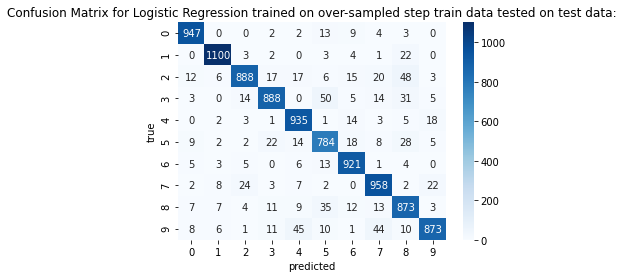


MutliClass ROC AUC score using labelBinarizer on prediction labels for Logistic Regression trained on over-sampled step train data and tested on test data:  0.9534318382828093
ROC AUC Score using probabilities for Logistic Regression trained on over-sampled step train data and tested on test data:  0.9930129261341587



In [60]:
loaded_overStep_logReg_model = pickle.load(open('overSampled_step_trained_LogReg.pkl','rb'))

y_predLogReg_step=loaded_overStep_logReg_model.predict(X_test_LR_RF)
y_probLogReg_step=loaded_overStep_logReg_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_overStep_logReg_model.best_params_)
print()
results(y_test, y_predLogReg_step, y_probLogReg_step, "over-sampled step train", "Logistic Regression")

Best Parameters from Grid CV is:  {'C': 0.01, 'max_iter': 100000000.0, 'solver': 'lbfgs'}



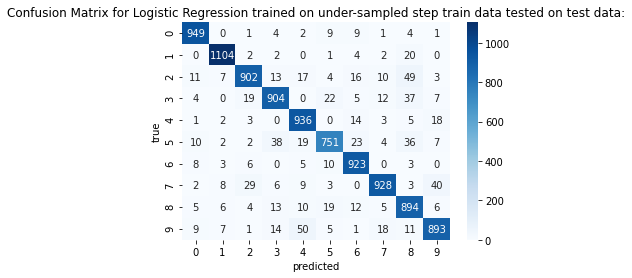


MutliClass ROC AUC score using labelBinarizer on prediction labels for Logistic Regression trained on under-sampled step train data and tested on test data:  0.9541873652159886
ROC AUC Score using probabilities for Logistic Regression trained on under-sampled step train data and tested on test data:  0.9928686359271426



In [61]:
loaded_underStep_logReg_model = pickle.load(open('underSampled_step_trained_LogReg.pkl','rb'))

y_predLogReg_step=loaded_underStep_logReg_model.predict(X_test_LR_RF)
y_probLogReg_step=loaded_underStep_logReg_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_underStep_logReg_model.best_params_)
print()
results(y_test, y_predLogReg_step, y_probLogReg_step, "under-sampled step train", "Logistic Regression")

# Linear Random Forest Models

Best Parameters from Grid CV is:  {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 150}



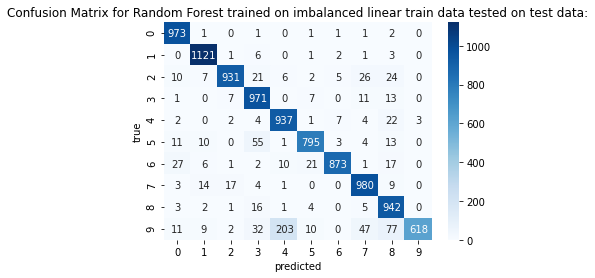


MutliClass ROC AUC score using labelBinarizer on prediction labels for Random Forest trained on imbalanced linear train data and tested on test data:  0.9519144016665582
ROC AUC Score using probabilities for Random Forest trained on imbalanced linear train data and tested on test data:  0.9964993008429681



In [62]:
loaded_imbalancedLinear_rf_model = pickle.load(open('imbalanced_linear_trained_rf.pkl','rb'))

y_predRF_linear=loaded_imbalancedLinear_rf_model.predict(X_test_LR_RF)
y_probRF_linear=loaded_imbalancedLinear_rf_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_imbalancedLinear_rf_model.best_params_)
print()
results(y_test, y_predRF_linear, y_probRF_linear, "imbalanced linear train", "Random Forest")

Best Parameters from Grid CV is:  {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 150}



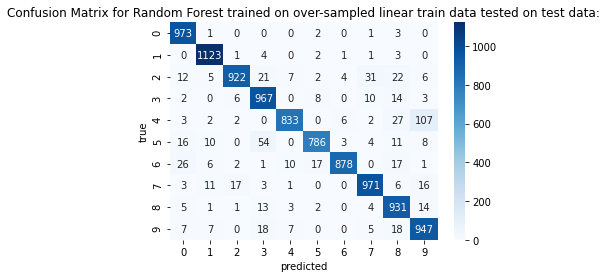


MutliClass ROC AUC score using labelBinarizer on prediction labels for Random Forest trained on over-sampled linear train data and tested on test data:  0.9621825526293971
ROC AUC Score using probabilities for Random Forest trained on over-sampled linear train data and tested on test data:  0.9969251665576296



In [63]:
loaded_overLinear_rf_model = pickle.load(open('overSampled_linear_trained_rf.pkl','rb'))

y_predRF_linear=loaded_overLinear_rf_model.predict(X_test_LR_RF)
y_probRF_linear=loaded_overLinear_rf_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_overLinear_rf_model.best_params_)
print()
results(y_test, y_predRF_linear, y_probRF_linear, "over-sampled linear train", "Random Forest")

Best Parameters from Grid CV is:  {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}



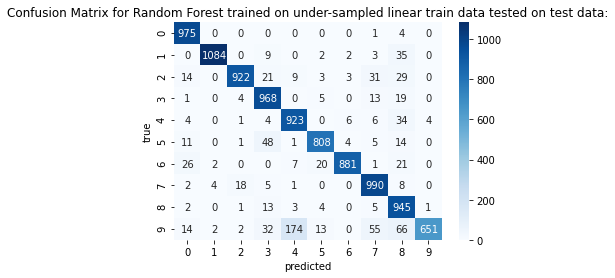


MutliClass ROC AUC score using labelBinarizer on prediction labels for Random Forest trained on under-sampled linear train data and tested on test data:  0.9525480745007775
ROC AUC Score using probabilities for Random Forest trained on under-sampled linear train data and tested on test data:  0.9963926342151801



In [64]:
loaded_underLinear_rf_model = pickle.load(open('underSampled_linear_trained_rf.pkl','rb'))

y_predRF_linear=loaded_underLinear_rf_model.predict(X_test_LR_RF)
y_probRF_linear=loaded_underLinear_rf_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_underLinear_rf_model.best_params_)
print()
results(y_test, y_predRF_linear, y_probRF_linear, "under-sampled linear train", "Random Forest")

# Step Random Forest Models

Best Parameters from Grid CV is:  {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 150}



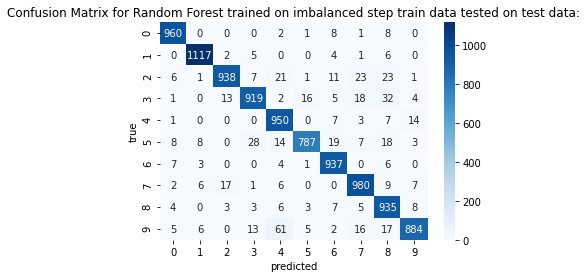


MutliClass ROC AUC score using labelBinarizer on prediction labels for Random Forest trained on imbalanced step train data and tested on test data:  0.9666935954355156
ROC AUC Score using probabilities for Random Forest trained on imbalanced step train data and tested on test data:  0.9971905412759714



In [65]:
loaded_imbalancedStep_rf_model = pickle.load(open('imbalanced_step_trained_rf.pkl','rb'))

y_predRF_step=loaded_imbalancedStep_rf_model.predict(X_test_LR_RF)
y_probRF_step=loaded_imbalancedStep_rf_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_imbalancedStep_rf_model.best_params_)
print()
results(y_test, y_predRF_step, y_probRF_step, "imbalanced step train", "Random Forest")

Best Parameters from Grid CV is:  {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}



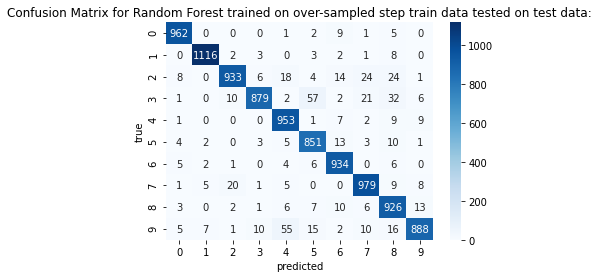


MutliClass ROC AUC score using labelBinarizer on prediction labels for Random Forest trained on over-sampled step train data and tested on test data:  0.9678830259615865
ROC AUC Score using probabilities for Random Forest trained on over-sampled step train data and tested on test data:  0.9973529221195363



In [66]:
loaded_overStep_rf_model = pickle.load(open('overSampled_step_trained_rf.pkl','rb'))

y_predRF_step=loaded_overStep_rf_model.predict(X_test_LR_RF)
y_probRF_step=loaded_overStep_rf_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_overStep_rf_model.best_params_)
print()
results(y_test, y_predRF_step, y_probRF_step, "over-sampled step train", "Random Forest")

Best Parameters from Grid CV is:  {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 150}



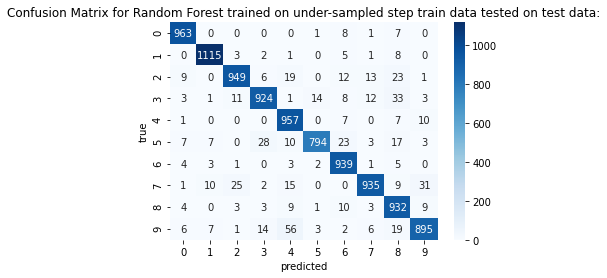


MutliClass ROC AUC score using labelBinarizer on prediction labels for Random Forest trained on under-sampled step train data and tested on test data:  0.9665722599457867
ROC AUC Score using probabilities for Random Forest trained on under-sampled step train data and tested on test data:  0.9972621697705751



In [67]:
loaded_underStep_rf_model = pickle.load(open('underSampled_step_trained_rf.pkl','rb'))

y_predRF_step=loaded_underStep_rf_model.predict(X_test_LR_RF)
y_probRF_step=loaded_underStep_rf_model.predict_proba(X_test_LR_RF)
print("Best Parameters from Grid CV is: ", loaded_underStep_rf_model.best_params_)
print()
results(y_test, y_predRF_step, y_probRF_step, "under-sampled step train", "Random Forest")